In [ ]:
!git clone https://github.com/kishkath/CIFAR10-OCP.git

Cloning into 'CIFAR10-OCP'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 61 (delta 29), reused 12 (delta 0), pack-reused 0
Unpacking objects: 100% (61/61), 18.31 KiB | 1.22 MiB/s, done.


In [ ]:
!pip install einops
!pip install pytorch-gradcam
!pip install torch_lr_finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 63.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5267 sha256=4ac871651302e7099d559c2b82d4ebbef3f220cec6937ef7151086390b10c7b8
  Stored in directory: /root/.cache/pip/wheels/dd/3c/0e/8b7512f5d7f462c9c37342107b7f0276609345f246ae4e75fc
Successfully built pytorch-gradcam
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
sys.path.append("/content/CIFAR10-OCP/")

In [ ]:
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from copy import deepcopy
from main import scores 

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from colorama import Fore,Style
import matplotlib.pyplot as plt
# python pip Libraries
from torch_lr_finder import LRFinder

from models import * 
from main import Performance,scores
from torchsummary import summary
from utils import mis_prediction,plotting_gradCams,loader,class_accuracy,Plot_curves,Draw

In [ ]:
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py

# Target1: Convert Linear Layers to Convolutional layers : DONE 
# Target2: Cls TOKEN + Patch Embeddings --> Position Encoding --> Transformer
# Target3: Flatten to 10 and train
# Target4: GRADCAM & MISCLASSIFIED
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# Residual network to add at the end of output.
class Residual(nn.Module):
  def __init__(self,*layers):
    super().__init__()
    self.residual = nn.Sequential(*layers)
    self.gamma = nn.Parameter(torch.zeros(1))
    # nn.Parameter means, the parameter in the paranthesis will be considered as trainable parameter which isn't the one before
    # nn.Parameter is a class in the PyTorch neural network module (torch.nn) that is used to create trainable parameters within a neural network model.
    # This means that it will be included in the computation of gradients during backpropagation and can be optimized by an optimizer.

  def forward(self,x):
    # print(x.shape,x+self.gamma*self.residual(x).shape)
    return x + self.gamma*self.residual(x) 
    # Adding residue at the end of output layer.

# classes
## Layer Normalization for input layers
class PreNorm(nn.Module):
    def __init__(self, dim):
      super().__init__()
      self.norm = nn.LayerNorm(dim)
    def forward(self, x, **kwargs):
      # print("Before transpose",x.shape)
      x = x.transpose(1,-1)
      # print("First transp",x.shape)
      x = self.norm(x)
      # print("After layernorm",x.shape)
      x = x.transpose(-1,1)
      # print("Transpoe tosl",x.shape)

      return x

class Embedding(nn.Module): 
  def __init__(self,dim,in_channels,channels,patch_size,p_drop=0.):
    super().__init__() 
    # COnverting to linear-embedding
    # input = 3, output = 32, kernel = 3, stride = 1, padding = 1 
    # output_Channels = 32 
    #----# 
    # input = 32,output = 32, kernel = patch_size = 2, stride = 2 
    # output_channels = (32-2)/2 = 16 + 1 = 17
    hidden_channels = 32
    self.to_patch_embedding = nn.Sequential(
        nn.Conv2d(in_channels,hidden_channels,3,1,1),
        nn.GELU(),
        nn.Conv2d(hidden_channels,channels,patch_size,patch_size)
    )
    # Didnt work becoz of different batch_sizes in cls & patch output 
    # self.cls_token = nn.Parameter(torch.randn(1,1,dim//patch_size,dim//patch_size))

    self.dropout = nn.Dropout(p_drop)
    # Position encoding to learn with weights 
    # self.pos_embedding = nn.Parameter(torch.randn(channels+1,16,16)) 


  def forward(self,x):
    x = self.to_patch_embedding(x)
    b,c,h,w = x.shape 

    y = nn.Parameter(torch.randn(b,1,dim//patch_size,dim//patch_size)).cuda()
    x = torch.cat((x,y),dim=1) 
    x_b,x_c,x_h,x_w = x.shape
    z = nn.Parameter(torch.randn(b,x_c,dim//patch_size,dim//patch_size)).cuda()
    x  += z 

    return x 

# Feed Forward Network from converting to linear layer 
class FeedForward(nn.Module):
    def __init__(self, in_channels, hidden_dim, dropout = 0.):
        super().__init__()
        hidden_dim *= 4 
        self.net = nn.Sequential(
            nn.Conv2d(dim+1, hidden_dim,1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(hidden_dim, dim+1,1),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

# Attention Mechanism by dividing them into heads, specifying keys, Queries, Values 
class Attention(nn.Module):
    def __init__(self, in_channels, out_channels,head_channels,shape):
        super().__init__()
        self.heads = out_channels//head_channels 
        self.head_channels = head_channels

        self.scale = head_channels**-0.5 

        self.to_keys = nn.Conv2d(in_channels,out_channels,1)
        self.to_values = nn.Conv2d(in_channels,out_channels,1)
        self.to_queries = nn.Conv2d(in_channels,out_channels,1)
        
        self.attend = nn.Softmax(dim = -1)

        self.to_out = nn.Sequential(nn.Conv2d(in_channels,out_channels,1)) 

    def forward(self, x):
      b,c,h,w = x.shape
    
      keys = self.to_keys(x).view(b,self.head_channels,self.heads,-1)
      values = self.to_values(x).view(b,self.head_channels,self.heads,-1)
      queries = self.to_values(x).view(b,self.head_channels,self.heads,-1)
   
      dots = torch.matmul(queries,keys.transpose(-1,-2)*self.scale)
      attn = self.attend(dots)
      out = torch.matmul(attn,values) 
      out = out.view(b,-1,h,w)
      return self.to_out(out)


class Transformer(nn.Sequential): 
  def __init__(self,channels,head_channels,shape,p_drop=0.):
    super().__init__(
        Residual(
            PreNorm(channels),
            Attention(channels,channels,head_channels,shape),
            nn.Dropout(p_drop)
        ),
        Residual(
            PreNorm(channels),
            FeedForward(channels,channels), 
            nn.Dropout(p_drop)
        )
    )

## Stacking the transformer block num_block times as a list 
class TransformerStack(nn.Sequential):
  def __init__(self,num_blocks,channels,head_channels,shape,p_drop=0.):
    layers = [Transformer(channels,head_channels,shape,p_drop) for _ in range(num_blocks)]
    super().__init__(*layers)
        


class ViT(nn.Module):
    def __init__(self,image_size, patch_size, num_classes, dim, depth, heads, mlp_dim,channels, pool = 'cls', in_channels = 3, dim_head = 64, head_p_drop=0.,trans_p_drop = 0., emb_p_drop = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        shape = (patch_height,patch_width)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
       
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        

        self.embedding = Embedding(dim,in_channels,channels,patch_size,p_drop=0.)
        self.tr = TransformerStack(depth,33,heads,shape,trans_p_drop)
        
        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            # nn.LayerNorm(dim+1),
            nn.Linear(256,dim+1),
            nn.Linear(dim+1, num_classes))

    def forward(self, img):
        x = self.embedding(img)
  
        x = self.tr(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        x = self.to_latent(x)
        x = x.view(x.size(0),256)
        return self.mlp_head(x)


In [ ]:
num_classes,image_size = 10,32
patch_size = 2 
dim = 32
depth = 4
heads = 8 
mlp_dim = 32
pool = 'cls'
out_channels = 32
model = ViT(image_size,patch_size,num_classes,dim,depth,heads,mlp_dim,out_channels,emb_p_drop=0., trans_p_drop=0., head_p_drop=0.1)

In [ ]:

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 
print(device," is  available!")
model.to(device)

cuda  is  available!


ViT(
  (embedding): Embedding(
    (to_patch_embedding): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (tr): TransformerStack(
    (0): Transformer(
      (0): Residual(
        (residual): Sequential(
          (0): PreNorm(
            (norm): LayerNorm((33,), eps=1e-05, elementwise_affine=True)
          )
          (1): Attention(
            (to_keys): Conv2d(33, 33, kernel_size=(1, 1), stride=(1, 1))
            (to_values): Conv2d(33, 33, kernel_size=(1, 1), stride=(1, 1))
            (to_queries): Conv2d(33, 33, kernel_size=(1, 1), stride=(1, 1))
            (attend): Softmax(dim=-1)
            (to_out): Sequential(
              (0): Conv2d(33, 33, kernel_size=(1, 1), stride=(1, 1))
            )
          )
          (2): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Re

In [ ]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 67,841


In [ ]:

import torchvision 
import torchvision.transforms as transforms 

IMAGE_SIZE = 32

NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 128
EPOCHS = 25

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-1

cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.75, 1.0), ratio=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandAugment(num_ops=1, magnitude=8),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
    transforms.RandomErasing(p=0.25)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=4)


Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


Plotting 10 test images!


0.frog 1.cat 2.horse 3.frog 4.horse 5.frog 6.cat 7.dog 8.horse 9.bird 10.cat


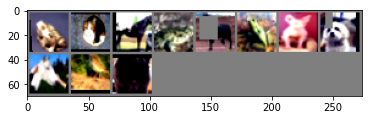

In [ ]:
plot_num_images = 11
classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(Style.BRIGHT+Fore.GREEN+f"Plotting {plot_num_images-1} test images!")
dataiter = next(iter(trainloader))
image_set , labels = dataiter
print(' '.join(str(j)+"."+'%1s' % classes[labels[j]] for j in range(plot_num_images)))
Draw.plotings(torchvision.utils.make_grid(image_set[:plot_num_images]))

Plotting 10 test images!


0.cat 1.ship 2.ship 3.plane 4.frog 5.frog 6.car 7.frog 8.cat 9.car 10.plane


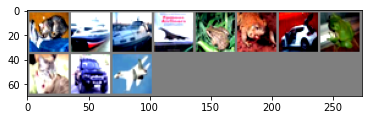

In [ ]:
plot_num_images = 11
print(Style.BRIGHT+Fore.GREEN+f"Plotting {plot_num_images-1} test images!")
dataiter = next(iter(testloader))
image_set , labels = dataiter
print(' '.join(str(j)+"."+'%1s' % classes[labels[j]] for j in range(plot_num_images)))
Draw.plotings(torchvision.utils.make_grid(image_set[:plot_num_images]))

In [ ]:

import time
import torch.optim as optim 
import numpy as np 
import torch.nn.functional as F 

# GradScaler is used for computing gradients and updating carefully such that no overflow and underflow happen.
# autocast, which converts high valued floating point numbers in to lower data type floating points such that to efficiently use memory and improve performance>

clip_norm = True
lr_schedule = lambda t: np.interp([t], [0, EPOCHS*2//5, EPOCHS*4//5, EPOCHS], 
                                  [0, 0.01, 0.01/20.0, 0])[0]

model = nn.DataParallel(model, device_ids=[0]).cuda()
opt = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
for epoch in range(EPOCHS):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    for i, (X, y) in enumerate(trainloader):
        model.train()
        X, y = X.cuda(), y.cuda() 
        lr = lr_schedule(epoch + (i + 1)/len(trainloader))
        opt.param_groups[0].update(lr=lr)

        opt.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(X)
            loss = criterion(output, y)

        scaler.scale(loss).backward()
        if clip_norm:
            scaler.unscale_(opt)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt)
        scaler.update()
        
        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)
        
    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)

    print(f'ConvMixer: Epoch: {epoch} | Train Acc: {train_acc/n:.4f}, Test Acc: {test_acc/m:.4f}, Time: {time.time() - start:.1f}, lr: {lr:.6f}')


ConvMixer: Epoch: 0 | Train Acc: 0.2095, Test Acc: 0.3495, Time: 71.3, lr: 0.001000
ConvMixer: Epoch: 1 | Train Acc: 0.3342, Test Acc: 0.3911, Time: 68.3, lr: 0.002000
ConvMixer: Epoch: 2 | Train Acc: 0.3636, Test Acc: 0.4303, Time: 69.9, lr: 0.003000
ConvMixer: Epoch: 3 | Train Acc: 0.3693, Test Acc: 0.3908, Time: 68.3, lr: 0.004000
ConvMixer: Epoch: 4 | Train Acc: 0.3683, Test Acc: 0.4162, Time: 68.4, lr: 0.005000
ConvMixer: Epoch: 5 | Train Acc: 0.3665, Test Acc: 0.4177, Time: 68.8, lr: 0.006000
ConvMixer: Epoch: 6 | Train Acc: 0.3683, Test Acc: 0.4044, Time: 69.6, lr: 0.007000
ConvMixer: Epoch: 7 | Train Acc: 0.3749, Test Acc: 0.3840, Time: 67.5, lr: 0.008000
ConvMixer: Epoch: 8 | Train Acc: 0.3630, Test Acc: 0.4228, Time: 67.7, lr: 0.009000
ConvMixer: Epoch: 9 | Train Acc: 0.3663, Test Acc: 0.3893, Time: 67.2, lr: 0.010000
ConvMixer: Epoch: 10 | Train Acc: 0.3610, Test Acc: 0.3590, Time: 68.6, lr: 0.009050
ConvMixer: Epoch: 11 | Train Acc: 0.3479, Test Acc: 0.3868, Time: 69.9, lr:

                              MISCLASSIFIED IMAGES                              




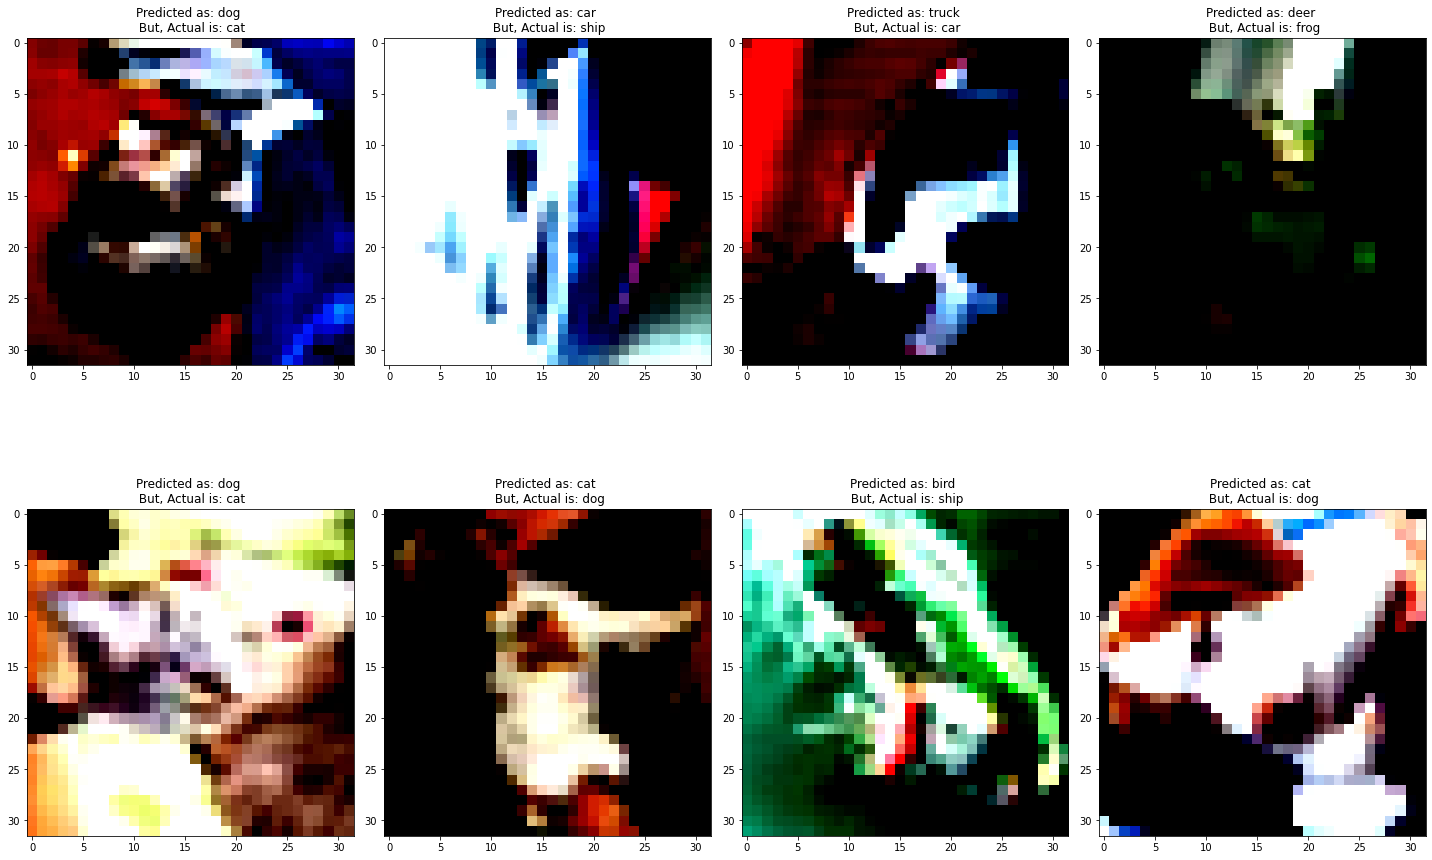

In [ ]:
print(" "*30+Style.BRIGHT+Fore.BLACK+"MISCLASSIFIED IMAGES"+" "*30)
print("\n")
# If you want n number of images to plot just pass the number as third parameter:
# like: mis_classsified(model,testloader,7,default is 10
Plot_curves.mis_classified(model,testloader,8)

                    GRAD-CAM usable diagnosistic IMAGES                    
Diagnosis is happening for Layer2 of ResNet18. Lets go!


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


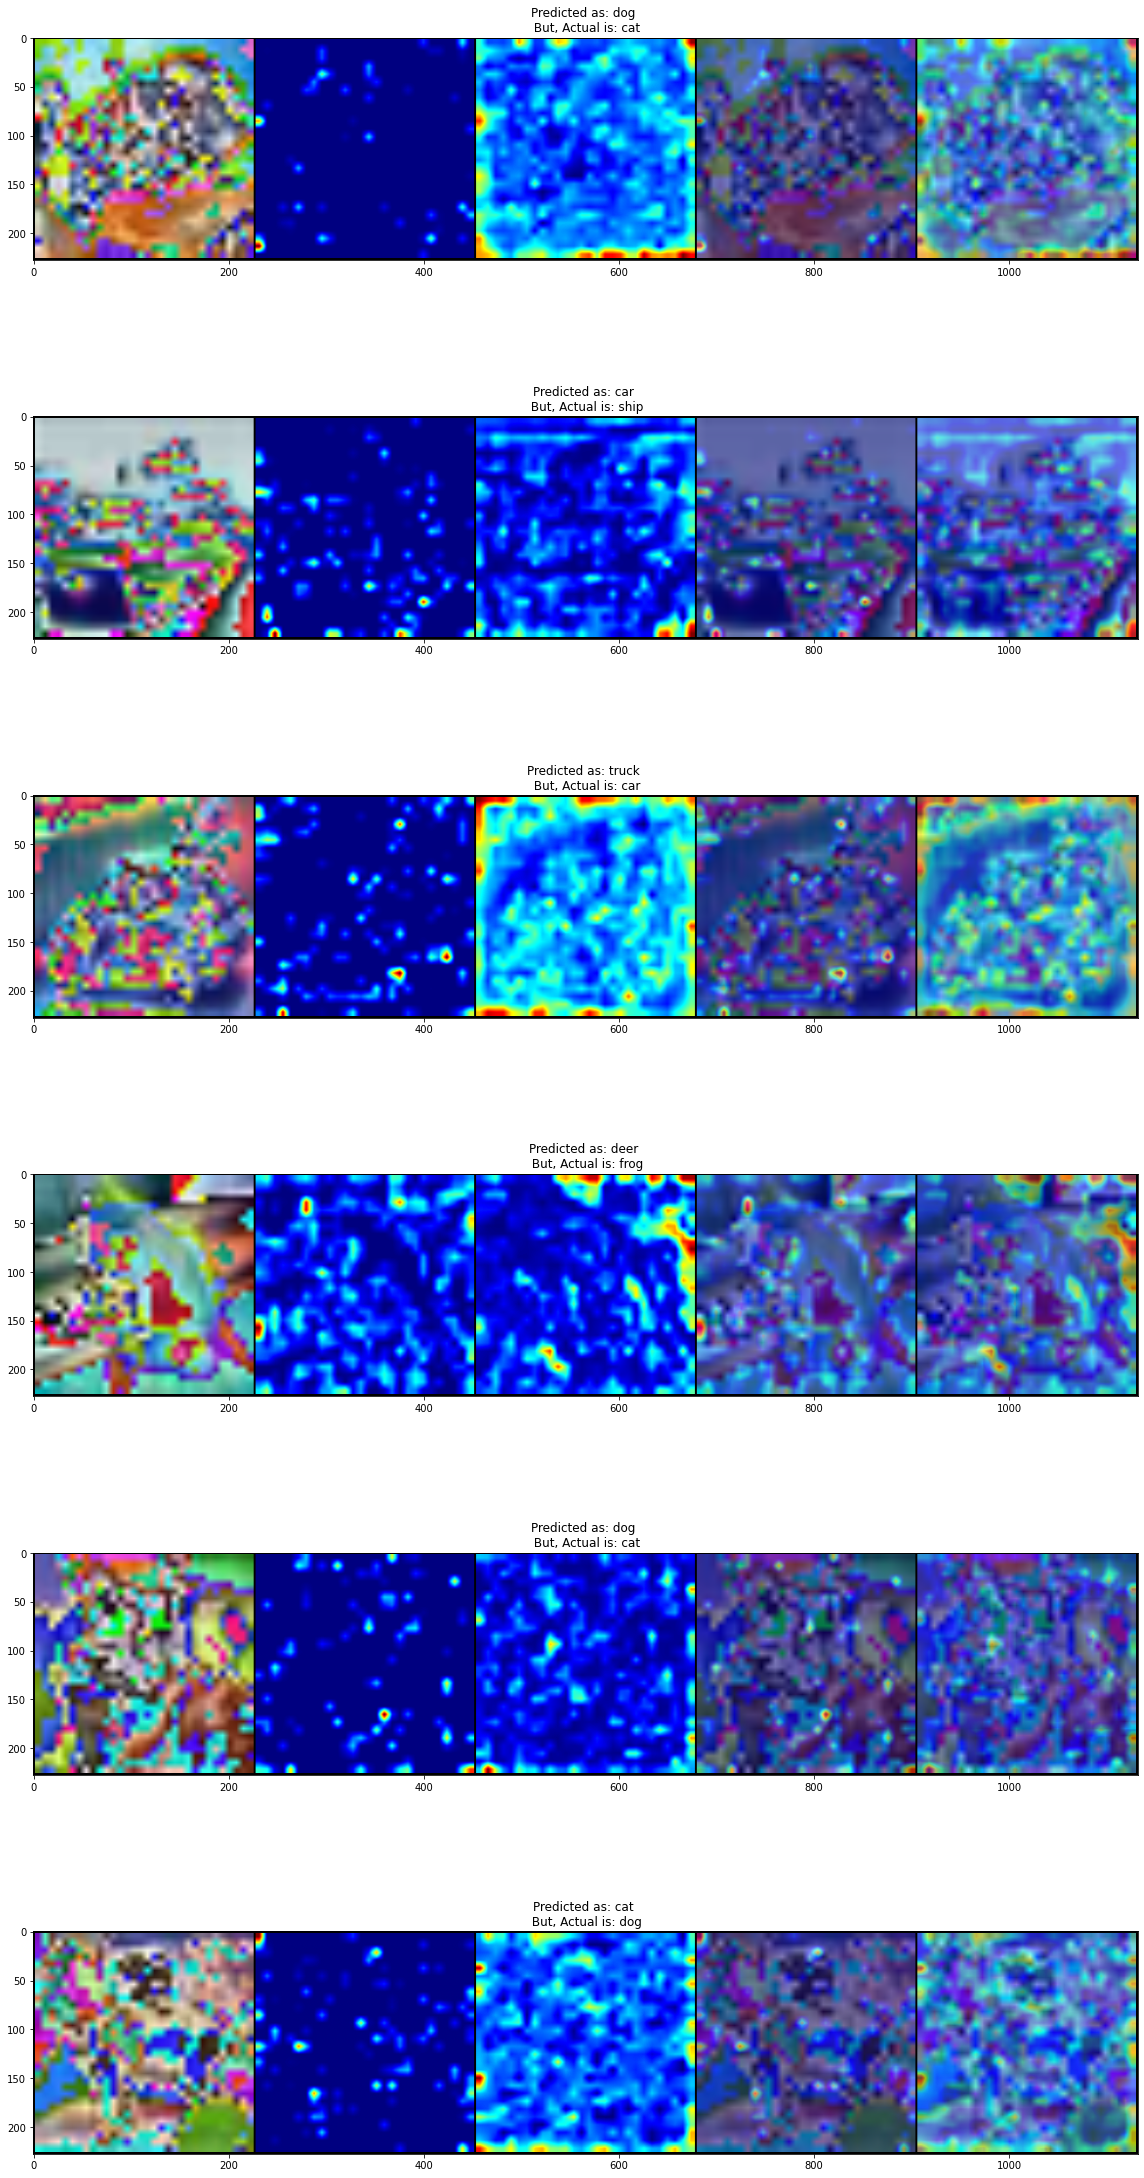

In [ ]:
## Can plots any number of images less than stored mis-classifed Images
print(" "*20+Style.BRIGHT+Fore.BLACK+"GRAD-CAM usable diagnosistic IMAGES"+" "*20)
plotting_gradCams(6)

In [ ]:
print("Not the best Architecture where cls_tokens & positional_embeddings are hard coded,need to modify!")

Not the best Architecture where cls_tokens & positional_embeddings are hard coded,need to modify!
